In [ ]:
!pip install opendatasets --upgrade

# Identifying Flower species using Deep Learning and PyTorch
1. Pick a dataset

2. Download the dataset

3. Import the dataset using PyTorch

4. Explore the dataset

5. Prepare the dataset for training

6. Move the dataset to the GPU

7. Train the model

8. Make predictions on sample images and Iterate iterate on it with differnt networks and hyperparameters

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'


In [ ]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')

In [ ]:
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


In [ ]:
data_dir = './flowers-recognition/flowers'

In [ ]:
import os
os.listdir(data_dir)

['dandelion', 'sunflower', 'daisy', 'rose', 'tulip']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':' , len(os.listdir(data_dir + '/' + cls)))

dandelion : 1052
sunflower : 733
daisy : 764
rose : 784
tulip : 984


# Import the data set using pytorch
 Use the 'ImageFolder' calssusing 'torchvision'


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

4317

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

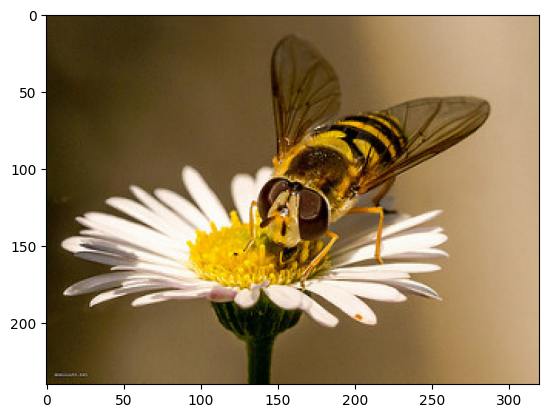

In [ ]:
img, lable  = dataset[200]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, transform = tt.Compose([tt.Resize(64),
                                                        tt.RandomCrop(64),
                                                        tt.ToTensor()]))

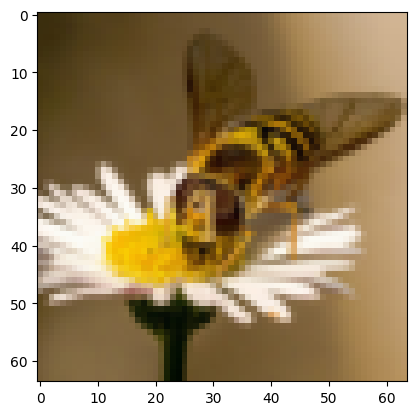

In [ ]:
img, lable  = dataset[200]
plt.imshow(img.permute((1,2,0)))

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size
train_size ,val_size

(3886, 431)

In [ ]:
from torch.utils.data import random_split

train_ds , valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:
from torch.utils.data import DataLoader

batch_size= 128
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

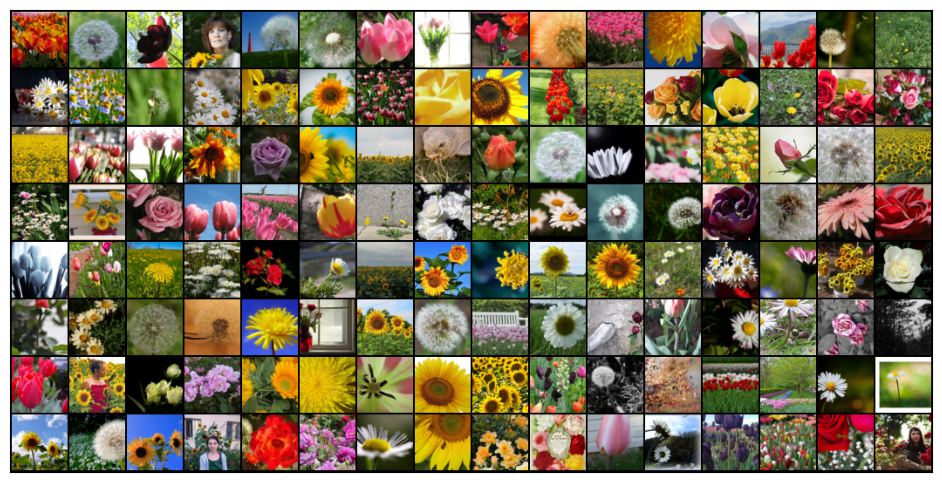

In [ ]:
show_batch(train_dl)

## Utiltiy functions and classes


In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img , label = dataset[0]

In [ ]:
img_gpu= to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilties

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Pass one batch of input tensor through the model.

In [ ]:
import torch

torch.cuda.empty_cache()

for batch in train_dl:
  images,labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


## Training

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.610959768295288, 'val_acc': 0.21941488981246948}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4596, val_loss: 1.4208, val_acc: 0.4021
Epoch [1], train_loss: 0.9677, val_loss: 0.9819, val_acc: 0.6051
Epoch [2], train_loss: 0.8452, val_loss: 1.0821, val_acc: 0.6015
Epoch [3], train_loss: 0.7820, val_loss: 0.7947, val_acc: 0.7160
Epoch [4], train_loss: 0.7123, val_loss: 0.6955, val_acc: 0.7462


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8303, val_loss: 0.8969, val_acc: 0.6833
Epoch [1], train_loss: 0.7027, val_loss: 0.7434, val_acc: 0.7495
Epoch [2], train_loss: 0.5824, val_loss: 0.6718, val_acc: 0.7501
Epoch [3], train_loss: 0.5481, val_loss: 0.8434, val_acc: 0.6945
Epoch [4], train_loss: 0.5279, val_loss: 0.7319, val_acc: 0.7384


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3977, val_loss: 0.5264, val_acc: 0.8179
Epoch [1], train_loss: 0.3613, val_loss: 0.5091, val_acc: 0.8417
Epoch [2], train_loss: 0.3322, val_loss: 0.5064, val_acc: 0.8285
Epoch [3], train_loss: 0.3180, val_loss: 0.4924, val_acc: 0.8257
Epoch [4], train_loss: 0.3113, val_loss: 0.5122, val_acc: 0.8106


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.2870, val_loss: 0.4767, val_acc: 0.8179
Epoch [1], train_loss: 0.2800, val_loss: 0.4750, val_acc: 0.8310
Epoch [2], train_loss: 0.2800, val_loss: 0.4849, val_acc: 0.8422
Epoch [3], train_loss: 0.2846, val_loss: 0.4938, val_acc: 0.8291
Epoch [4], train_loss: 0.2822, val_loss: 0.4722, val_acc: 0.8408


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

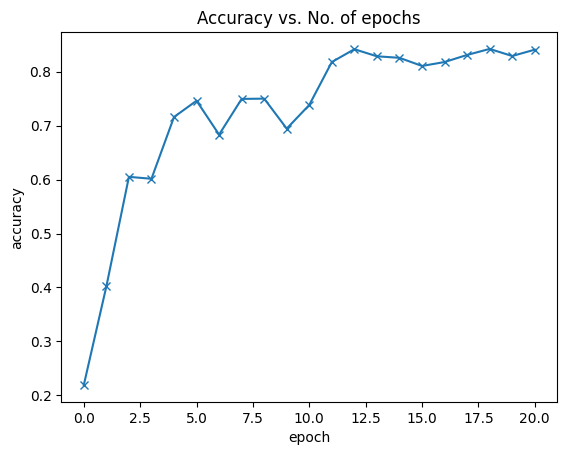

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

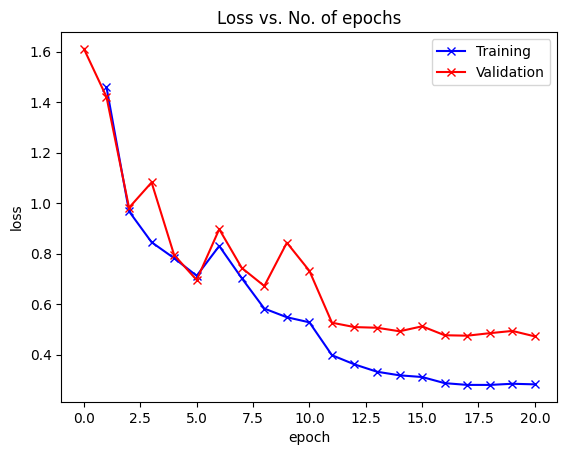

In [ ]:
plot_losses(history)

## Record the Results

In [ ]:
 import pandas as pd

# Assuming your 'history' list is already filled from the fit function
df = pd.DataFrame(history)
df.to_csv("results.csv", index_label="Epoch")


In [ ]:
final = history[-1]
print(f"""
🌸 Flower Classification - Results Summary

- Total Epochs: {len(history)}
- Final Validation Accuracy: {final['val_acc'] * 100:.2f}%
- Final Training Loss: {final['train_loss']:.4f}
- Final Validation Loss: {final['val_loss']:.4f}
""")



🌸 Flower Classification - Results Summary

- Total Epochs: 21
- Final Validation Accuracy: 84.08%
- Final Training Loss: 0.2822
- Final Validation Loss: 0.4722



## Test with individual image

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: daisy
Prediction: daisy


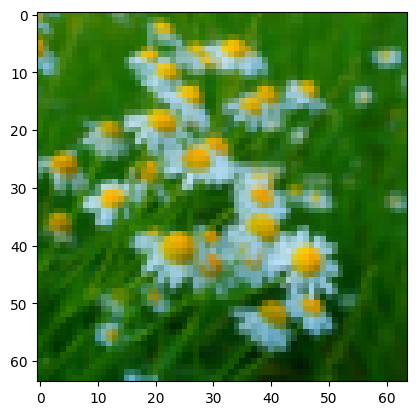

In [ ]:
show_image_prediction(*valid_ds[100])

Target: daisy
Prediction: daisy


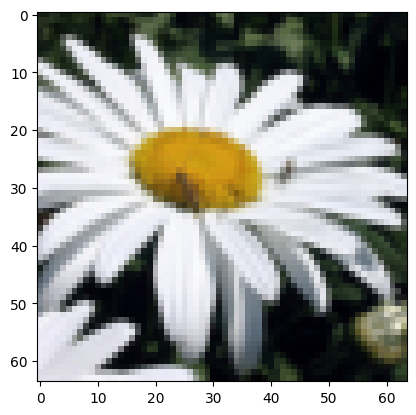

In [ ]:
show_image_prediction(*valid_ds[200])

Target: dandelion
Prediction: dandelion


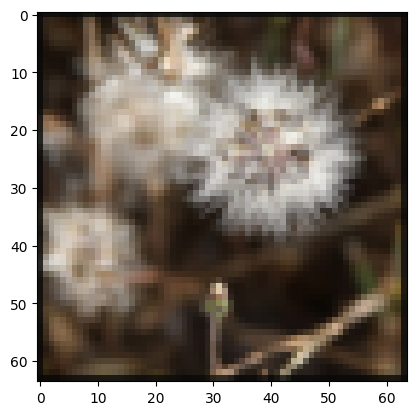

In [ ]:
show_image_prediction(*valid_ds[19])

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')